In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, cv2, random

caffe_root = '/home/heyanguang/caffecode/caffe/'
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
import caffe

sys.path.append('./examples/coco_caption')

# iter_num = 110000
# net = caffe.Net('./examples/coco_caption/lstm_lm.deploy.prototxt',
#                 './examples/coco_caption/lstm_lm_iter_%d.caffemodel' % iter_num, caffe.TEST)
# print net.blobs['probs'].data.shape

iter_num = 110000
net = caffe.Net('./examples/coco_caption/lrcn.deploy.prototxt',
                './examples/coco_caption/lrcn_iter_%d.caffemodel' % iter_num, caffe.TEST)
print "net.blobs['probs']", net.blobs['probs'].data.shape

net.blobs['probs'] (1, 1, 8801)


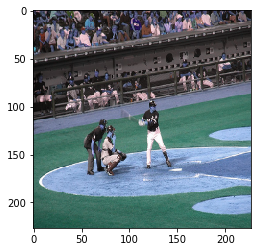

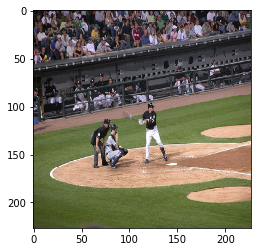

In [117]:
# for k, v in net.blobs.items():
#     print k, v.data.shape
net.forward(input_sentence = np.array([0]), cont_sentence = np.array([0]))
im = net.blobs['data'].data
c0 = np.ones((227, 227)) * 104
c1 = np.ones((227, 227)) * 117
c2 = np.ones((227, 227)) * 123
mean = np.zeros((1, 3, 227, 227))
mean[0, 0, :] = c0
mean[0, 1, :] = c1
mean[0, 2, :] = c2
plt.imshow((im + mean)[0].transpose(1, 2, 0).astype('uint8'))
plt.show()

im = caffe.io.load_image('data/coco/coco/images/train2014/COCO_train2014_000000340314.jpg')
im = caffe.io.resize_image(im, (227, 227))
plt.imshow(im)
plt.show()

In [130]:
def predict_single_word_pic(net, previous_word, output = 'probs'):
    cont = 0 if previous_word == 0 else 1
    cont_input = np.array([cont])
    word_input = np.array([previous_word])
    net.forward(cont_sentence = cont_input, input_sentence = word_input)
    output_preds = net.blobs[output].data[0, 0, :]
    return output_preds

In [131]:
first_word_dist = predict_single_word_pic(net, 0)
vocabulary = ['<EOS>'] + [line.strip() for line in
                          open('examples/coco_caption/h5_data/buffer_100/vocabulary.txt').readlines()]
print len(vocabulary)
print np.array(vocabulary)[0:50]

8801
['<EOS>' '<unk>' 'a' 'on' 'of' 'the' 'in' 'with' 'and' 'is' 'man' 'to'
 'sitting' 'an' 'two' ',' 'standing' 'at' 'people' 'are' 'next' 'white'
 'woman' 'table' 'street' 'that' 'holding' 'it' 'person' 'large' 'some'
 'down' 'top' 'group' 'up' 'field' 'small' 'near' 'tennis' 'his' 'front'
 'black' 'plate' 'room' 'train' 'dog' 'riding' 'red' 'by' 'young']


In [132]:
# Arrange small real number first.
top_preds = np.argsort(-1 * first_word_dist)
print top_preds[:10]
print [vocabulary[index] for index in top_preds[:10]]

[  2   5  52  64  14  30 394  13  18  93]
['a', 'the', 'baseball', 'there', 'two', 'some', 'batter', 'an', 'people', 'several']


In [133]:
def softmax(softmax_inputs, temp):
    shifted_inputs = softmax_inputs - softmax_inputs.max()
    exp_outputs = np.exp(temp * shifted_inputs)
    exp_outputs_sum = exp_outputs.sum()
    if np.isnan(exp_outputs_sum):
        return exp_outputs * float('nan')
    assert exp_outputs_sum > 0
    if np.isinf(exp_outputs_sum):
        return np.zeros_like(exp_outputs)
    eps_sum = 1e-20
    return exp_outputs / max(exp_outputs_sum, eps_sum)

def random_choice_from_probs(softmax_inputs, temp = 1):
    # temperature of infinity == take the max
    if temp == float('inf'):
        return np.argmax(softmax_inputs)
    probs = softmax(softmax_inputs, temp)
    r = random.random()
    cum_sum = 0.
    for i, p in enumerate(probs):
        cum_sum += p
        if cum_sum >= r: return i
    return 1  # return UNK?

In [217]:
def generate_sentence(net, temp = float('inf'), output = 'predict', max_words = 50):
    cont_input = np.array([1])
    word_input = np.array([29])
    sentence = []
    while len(sentence) < max_words and (not sentence or sentence[-1] != 0):
        net.forward(cont_sentence = cont_input, input_sentence = word_input)
        output_preds = net.blobs[output].data[0, 0, :]
        sentence.append(random_choice_from_probs(output_preds, temp = temp))
        cont_input[0] = 1
        word_input[0] = sentence[-1]
    return sentence

sentence = generate_sentence(net, temp = 0.5)
print sentence
print [vocabulary[index] for index in sentence]

[1583, 1897, 6892, 743, 1759, 42, 501, 1909, 89, 3691, 3847, 6569, 1107, 7558, 5526, 7065, 1210, 236, 5052, 6087, 3448, 973, 91, 54, 1598, 308, 3445, 17, 6200, 3965, 1656, 102, 21, 3587, 4320, 343, 7779, 3729, 861, 1278, 2806, 6014, 1333, 7948, 7632, 357, 12, 7800, 5661, 5455]
['daytime', 'pedestal', 'mic', 'where', 'observing', 'plate', 'sunny', 'link', 'player', 'packing', 'boulders', 'pomegranates', 'throws', 'blinder', 'ribs', 'widow', 'art', 'taking', 'ripped', 'amateur', 'glow', 'leading', 'game', 'while', 'fans', 'getting', 'fell', 'at', 'inviting', 'shears', ';', 'one', 'white', 'support', 'wades', 'waiting', 'inscription', 'bunt', 'turn', 'fallen', 'oncoming', 'popsicle', 'lane', 'skiiing', 'criss', 'about', 'sitting', 'knights', 'enthusiastically', 'enforcement']
